In [11]:
import torch 
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [12]:
# Defining Kernel, we'll use Sobel kernel for horizontal change for now

sobel_kernel = torch.tensor([[-1.,0.,1.],
                       [-2.,0.,2.], 
                       [-1.,0.,1.]
                      ])
# need it to be weight of shape (1,1,3,3) 1 for input/output 3x3 for kernel size
sobel_kernel = sobel_kernel.view(1,1,3,3)

In [13]:
# building a training set using torchvision's MNIST dataset
class KernelDataset(Dataset):
    def __init__(self,kernel = sobel_kernel, train = True):
        self.ds = datasets.MNIST(
            root = '.',
            train = train,
            download = True,
            transform = transforms.ToTensor()
        )

    # we make a copy of our kernel just in case
        self.kernel = kernel.clone().float()

    # define getitem and len 
    # 1) grab image at index idx,
    # 2) apply 2D convolution to x
    # 3) pytorch expects batches so we unsqueeze input and squeeze output ( to set batch size as 1)
    
    def __getitem__(self,idx):
        x, _  = self.ds[idx]
        x = x.float().unsqueeze(0)
        y = torch.nn.functional.conv2d(x, self.kernel,stride = 1, padding = 1).squeeze(0)
        return x.squeeze(0), y

    def __len__(self):
        return len(self.ds)

In [15]:
# create data loaders for training and validation sets

# we'll shuffle during training to reduce liklihood model trains on small subset of paterns
train_loader = DataLoader(KernelDataset(train = True), batch_size = 64, shuffle = True)
val_loader = DataLoader(KernelDataset(train = False), batch_size = 64)



In [16]:
# Define test architectures

# single convolution layer neuron: input > convolution w/sobel kernel > output
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1,1,3,padding = 1, bias = False)

    def forward(self,x):
        return self.conv(x)

#  1-layer linear neuron (not techincally MLP) has no activation function
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784,784), #1*28*28
            nn.Unflatten(1,(1,28,28))
        )
    def forward(self,x):
        return self.net(x)



        
## transformers ingest vectors (tokens), not images, so must convert input 
# we make sequences of patches (cut-outs) of each image using a 1x1 convolution and convert to a sequence of tokens

class Transformer(nn.Module):
    def __init__(self,dim = 32):
        super().__init__()
        self.patch_embed = nn.Conv2d(in_channels = 1, out_channels = dim, kernel_size = 1)
        self.encoder = nn.TransformerEncoderLayer(
            d_model = dim,
            nhead = 4, 
            batch_first = True
        )
        self.unpatch = nn.Conv2d(in_channels = dim, out_channels = 1, kernel_size = 1)
        
    def forward(self,x):
        B,C,H,W = x.shape
        # Patch and reshape into sequence of tokens
        x= self.patch_embed(x) 
        x = x.flatten(2) 
        x = x.transpose(1,2) 

        # Pass through transformer
        x = self.encoder(x)
        
        # Reshape and project back to 1 channel image
        x = x.transpose(1,2)
        if x.size(2) != H * W:
          raise ValueError(f"Shape mismatch: expected {H * W} elements, got {x.size(2)}")
            
        x = x.view(B,-1,H,W)
        out = self.unpatch(x)

        return out

In [22]:
def train(model, train_loader, val_loader, epochs = 5, lr = 1e-3):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    # and we'll use mean squared error to calculate loss
    loss_fun = nn.MSELoss()

    # training step: forward > calculate loss > optimize via gradient des > update > print loss
    for ep in range(epochs):
        model.train()
        total = 0

        # for each pair of (image, label) compute on GPU, use loss function to 
     
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            
            # calculate gradients 
            optimizer.zero_grad()
            pred = model(x)
            loss = loss_fun(pred, y)
            loss.backward()
            # and update weights 
            optimizer.step()

            # we keep track of total loss
            total+= loss.item()
            
        print(f"Epoch {ep+1}: train loss = {total/len(train_loader):.6f}")

        # validation step: forward > loss > print loss
        with torch.no_grad():
            model.eval()
            val_total = 0
            for x,y in val_loader:
                x = x.to(device)
                y = y.to(device)

                pred = model(x)
                val_loss = loss_fun(pred,y)
                val_total += val_loss.item()
            print(f" val loss = {val_total/len(val_loader):.6f}")
            

# CNN

In [24]:
model = CNN()
train(model, train_loader, val_loader, epochs = 5)


Epoch 1: train loss = 0.573845
 val loss = 0.197135
Epoch 2: train loss = 0.085456
 val loss = 0.031265
Epoch 3: train loss = 0.019919
 val loss = 0.012896
Epoch 4: train loss = 0.009190
 val loss = 0.006041
Epoch 5: train loss = 0.004247
 val loss = 0.002724


In [42]:
learned_kernel = model.conv.weight.data.view(-1)

# ensuring tensors are on same device for cosine comparison, cosine_similarity requires 1D vectors so reshape
true_kernel = sobel_kernel.to(model.conv.weight.device).view(-1)
cos = F.cosine_similarity(learned_kernel, true_kernel, dim = 0)
print("cosine similarity: {}".format(cos.item()))

x,_ = next(iter(val_loader))
x = x.to(device)

sobel = sobel_kernel.to(device) # 
with torch.no_grad():
    true_sobel = F.conv2d(x,sobel, stride = 1, padding = 1)
    pred = model(x)
    
mse = F.mse_loss(pred,true_sobel)
print("CNN vs Sobel MSE error is: {}".format(mse.item()))

cosine similarity: 0.9844310283660889
CNN vs Sobel MSE error is: 0.0020872612949460745


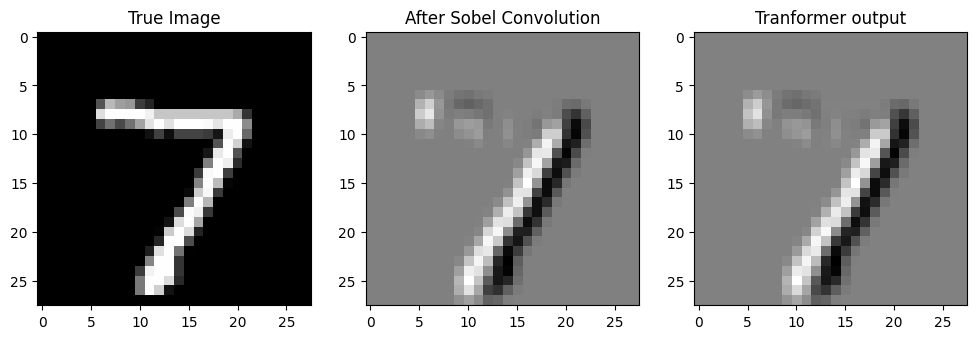

In [43]:
plt.figure(figsize= (12,4))
plt.subplot(1,3,1)
plt.title("True Image")
plt.imshow(x[0,0].cpu(),cmap = 'gray')

plt.subplot(1,3,2)
plt.title("After Sobel Filter")
plt.imshow(true_sobel[0,0].cpu(), cmap = 'gray')

plt.subplot(1,3,3)
plt.title("CNN output")
plt.imshow(pred[0,0].cpu(), cmap = 'gray')


# MLP

Unlike the CNN wihch does have a 2D convolutional filter, NLP trains weights so we will just measure performance via MSE to see how well it learns the filter.

In [8]:
model = MLP()
train(model, train_loader, val_loader, epochs = 5)


Epoch 1: train loss = 0.301417
 val loss = 0.109106
Epoch 2: train loss = 0.068498
 val loss = 0.040150
Epoch 3: train loss = 0.027420
 val loss = 0.017446
Epoch 4: train loss = 0.011863
 val loss = 0.007531
Epoch 5: train loss = 0.004968
 val loss = 0.003070


In [9]:
x,_ = next(iter(val_loader))
x = x.to(device)

sobel = sobel_kernel.to(device) # shape [1,1,3,3]
with torch.no_grad():
    true_sobel = F.conv2d(x,sobel, stride = 1, padding = 1)
    pred = model(x)
    
mse = F.mse_loss(pred,true_sobel)
print("MLP vs Sobel MSE error is: {}".format(mse.item()))

MLP vs Sobel MSE error is: 0.003179865190759301


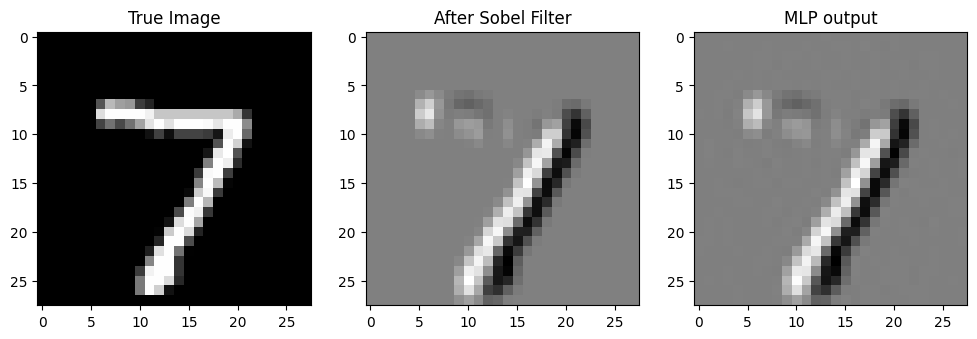

In [10]:
plt.figure(figsize= (12,4))
plt.subplot(1,3,1)
plt.title("True Image")
plt.imshow(x[0,0].cpu(),cmap = 'gray')

plt.subplot(1,3,2)
plt.title("After Sobel Filter")
plt.imshow(true_sobel[0,0].cpu(), cmap = 'gray')

plt.subplot(1,3,3)
plt.title("MLP output")
plt.imshow(pred[0,0].cpu(), cmap = 'gray')


# Transformer

In [18]:
model = Transformer()
train(model, train_loader, val_loader, epochs = 5)

Epoch 1: train loss = 1.151640
 val loss = 1.158893
Epoch 2: train loss = 1.147977
 val loss = 1.158910
Epoch 3: train loss = 1.147992
 val loss = 1.158907
Epoch 4: train loss = 1.147977
 val loss = 1.158886
Epoch 5: train loss = 1.147914
 val loss = 1.158875


In [19]:
x,_ = next(iter(val_loader))
x = x.to(device)

sobel = sobel_kernel.to(device) # shape [1,1,3,3]
with torch.no_grad():
    true_sobel = F.conv2d(x,sobel, stride = 1, padding = 1)
    pred = model(x)
    
mse = F.mse_loss(pred,true_sobel)
print("Transformer vs Sobel MSE error is: {}".format(mse.item()))

Transformer vs Sobel MSE error is: 1.1575678586959839


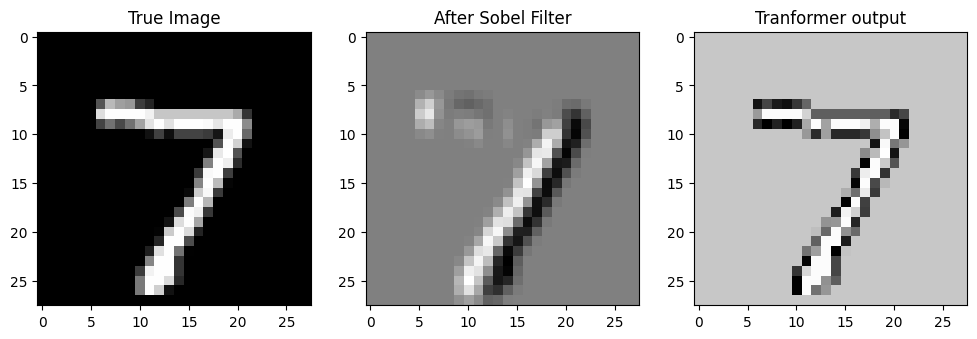

In [20]:
plt.figure(figsize= (12,4))
plt.subplot(1,3,1)
plt.title("True Image")
plt.imshow(x[0,0].cpu(),cmap = 'gray')

plt.subplot(1,3,2)
plt.title("After Sobel Filter")
plt.imshow(true_sobel[0,0].cpu(), cmap = 'gray')

plt.subplot(1,3,3)
plt.title("Tranformer output")
plt.imshow(pred[0,0].cpu(), cmap = 'gray')


We'll now vary the parameters of our transformer to hopefully build a phase diagram